Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH
Библиотеки: [Python, Tensorflow]

In [1]:
import skvideo
skvideo.setFFmpegPath('C:\ProgramData\Anaconda3\Lib\site-packages\skvideo\io')
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import skvideo.io
import tensorflow as tf

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION']='true'

## Подготовка датасета для классификации

In [3]:
patch = r'D:\train\video'

In [4]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(patch+'\\', cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [5]:
len(dataset)

599

In [6]:
TEST_LEN = 90
random.shuffle(dataset)
tr_dataset = dataset[TEST_LEN:]
test_dataset =dataset[:TEST_LEN]

print('Dataset samples (subset):', len(tr_dataset),len(test_dataset))

Dataset samples (subset): 509 90


## Визуализация кадра из видео

videodata shape: (515, 120, 160, 3)


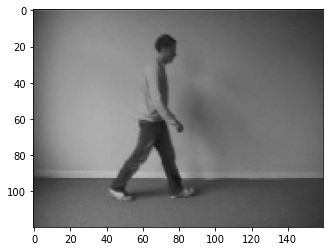

In [9]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

## Визуализация "движения"

motion shape: (514, 120, 160, 1)


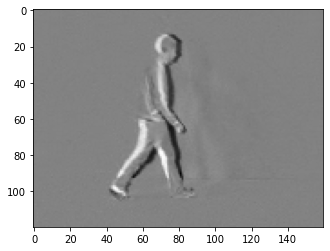

In [11]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0],cmap='gray')

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [35]:
inp = videodata[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 515, 120, 160, 3)
Output shape: (1, 6)


In [37]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),metrics=['accuracy'])

In [7]:
def make_bach(batch,data):
    x_train=[]
    n = len(data)//batch
    for k in range(n):
        x_train.append(([i[0] for i in data[batch*k:batch*(k+1)]],[i[1] for i in data[batch*k:batch*(k+1)]]))
    return x_train    
    

In [8]:
# Разобъем на бачи
x_train=make_bach(batch = 1,data =tr_dataset )


In [9]:
len(x_train)

509

In [39]:
%%time
size_video = 300
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter_, (fpath, label) in enumerate(x_train):
        for n,p in enumerate(fpath):
            videodata = skvideo.io.vread(p)
            videodata = videodata.astype(np.float32) / 255.
            motion = np.mean(videodata[1:, ] - videodata[:-1, ...], axis=3, keepdims=True)
            s = motion.shape[0]
            if s>size_video:
                x = motion[:size_video]
            else:
                d = size_video - s
                zer = np.zeros(((d,)+(120,160,1)))
                x = np.vstack((motion,zer))
            x = x[None, ]
            if n==0:
                z = x.copy()
                continue   
            z = np.append(z,x,axis=0) 
    
        y = np.array(label)
        y= y.reshape(-1,1)
        loss_value = model.train_on_batch(z, y)

        if iter_ % 10 == 0:
            print(f'[{ep+1}/{NUM_EPOCHS}][{iter_}/{int(len(x_train))}] Loss = {loss_value}')

            

        global_step += 1

[1/10][0/169] Loss = [0.17573004961013794, 1.0]
[1/10][10/169] Loss = [0.007751472294330597, 1.0]
[1/10][20/169] Loss = [0.36010029911994934, 0.6666666865348816]
[1/10][30/169] Loss = [0.001191664021462202, 1.0]
[1/10][40/169] Loss = [0.003921279218047857, 1.0]
[1/10][50/169] Loss = [0.05436888709664345, 1.0]
[1/10][60/169] Loss = [0.21808135509490967, 1.0]
[1/10][70/169] Loss = [0.0036773551255464554, 1.0]
[1/10][80/169] Loss = [0.3199290931224823, 1.0]
[1/10][90/169] Loss = [0.14137601852416992, 1.0]
[1/10][100/169] Loss = [0.08170822262763977, 1.0]
[1/10][110/169] Loss = [0.0002811370650306344, 1.0]
[1/10][120/169] Loss = [0.008624574169516563, 1.0]
[1/10][130/169] Loss = [0.1034468486905098, 1.0]
[1/10][140/169] Loss = [0.3592594563961029, 0.6666666865348816]
[1/10][150/169] Loss = [0.03167999908328056, 1.0]
[1/10][160/169] Loss = [0.010461085475981236, 1.0]
[2/10][0/169] Loss = [0.46125686168670654, 0.6666666865348816]
[2/10][10/169] Loss = [0.003152400255203247, 1.0]
[2/10][20/16

[10/10][50/169] Loss = [0.03761240467429161, 1.0]
[10/10][60/169] Loss = [0.0028432169929146767, 1.0]
[10/10][70/169] Loss = [0.0002891557523980737, 1.0]
[10/10][80/169] Loss = [0.08434175699949265, 1.0]
[10/10][90/169] Loss = [0.029127230867743492, 1.0]
[10/10][100/169] Loss = [0.005696067586541176, 1.0]
[10/10][110/169] Loss = [1.5496849300689064e-05, 1.0]
[10/10][120/169] Loss = [0.0007611137698404491, 1.0]
[10/10][130/169] Loss = [0.03502456843852997, 1.0]
[10/10][140/169] Loss = [0.042422592639923096, 1.0]
[10/10][150/169] Loss = [0.0074846199713647366, 1.0]
[10/10][160/169] Loss = [3.178912777457299e-07, 1.0]
Wall time: 39min 9s


## Качество обученной модели

In [27]:
x_test = make_bach(batch=1,data=test_dataset)

In [44]:
%%time
true_answrs = 0
count = 0

for iter_, (fpath, label) in enumerate(x_test):
        for n,p in enumerate(fpath):
            videodata = skvideo.io.vread(p)
            videodata = videodata.astype(np.float32) / 255.
            motion = np.mean(videodata[1:, ] - videodata[:-1, ...], axis=3, keepdims=True)
            s = motion.shape[0]
            if s>size_video:
                x = motion[:size_video]
            else:
                d = size_video - s
                zer = np.zeros(((d,)+(120,160,1)))
                x = np.vstack((motion,zer))
            x = x[None, ]
            if n==0:
                z = x.copy()
                continue   
            z = np.append(z,x,axis=0) 
    
        answer = model(z) 
        answer = np.argmax(answer.numpy(),axis=1)      
        y = np.array(label)
        count +=len(y)
        true_answrs +=sum(answer==y)
        

print(f' accuracy по тесту {round(true_answrs/count,2)}')

 accuracy по тесту 0.91
Wall time: 31.8 s


## Попоробум GRU

In [11]:
LEARNING_RATE = 0.0001
loss=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam(LEARNING_RATE)

In [12]:


input_x = tf.keras.layers.Input(shape=(120, 160, 3))
x = tf.keras.layers.Conv2D(64,3,padding = 'same',activation = 'relu')(input_x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)#60*80
x = tf.keras.layers.Conv2D(128,3,padding = 'same',activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)# 30*40
x = tf.keras.layers.Conv2D(256,3,padding = 'same',activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)# 15*20
x = tf.keras.layers.Conv2D(512,3,strides = 3,activation = 'relu')(x)# 5*10
x = tf.keras.layers.MaxPooling2D(2,2)(x)# 2*5
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128,activation = 'relu')(x)  
x = tf.keras.layers.Dense(64,activation = None)(x)
out= tf.expand_dims(x,axis=1)

model_pict = tf.keras.Model(input_x,out)
model_pict.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 160, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 80, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 80, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 40, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 20, 256)       0     

In [13]:
input_x = tf.keras.layers.Input(shape=(300, 64))
x = tf.keras.layers.GRU(512)(input_x)
x = tf.keras.layers.Dense(128,activation = 'relu')(x)  
out = tf.keras.layers.Dense(6,activation = 'softmax')(x)
model_finish = tf.keras.Model(input_x,out)
model_finish.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 64)]         0         
_________________________________________________________________
gru (GRU)                    (None, 512)               887808    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 954,246
Trainable params: 954,246
Non-trainable params: 0
_________________________________________________________________


In [14]:
%%time
NUM_EPOCHS = 10
size_video = 300
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter_, (fpath, label) in enumerate(x_train):
        for n,p in enumerate(fpath):
            videodata = skvideo.io.vread(p)
            videodata = videodata.astype(np.float32) / 255.
            s = videodata.shape[0]
            if s>size_video:
                x = videodata[:size_video]
            else:
                d = size_video - s
                zer = np.zeros(((d,)+(120,160,3)))
                x = np.vstack((videodata,zer))  
            with tf.GradientTape() as tape:
                for num,pic in enumerate(x):
                    pic = pic[None,]
                    emb = model_pict(pic)
                    if num==0:
                        y=emb
                        continue
                    y = tf.concat([y,emb],axis=1)   
                res = model_finish(y) 
                loss_value = loss(label,res)
            # Backward
            grads = tape.gradient(loss_value,  model_finish.variables+model_pict.variables)
            optimizer.apply_gradients(zip(grads, model_finish.variables+model_pict.variables))     

        if iter_ % 10 == 0:
            print(f'[{ep+1}/{NUM_EPOCHS}][{iter_}/{int(len(x_train))}] Loss = {loss_value}')

            

        global_step += 1

[1/10][0/509] Loss = 1.7831424474716187
[1/10][10/509] Loss = 1.6900171041488647
[1/10][20/509] Loss = 1.805558681488037
[1/10][30/509] Loss = 1.892350196838379
[1/10][40/509] Loss = 1.8253272771835327
[1/10][50/509] Loss = 1.8201398849487305
[1/10][60/509] Loss = 1.788499355316162
[1/10][70/509] Loss = 1.7979826927185059
[1/10][80/509] Loss = 1.795272946357727
[1/10][90/509] Loss = 1.772851824760437
[1/10][100/509] Loss = 1.8178119659423828
[1/10][110/509] Loss = 1.808227300643921
[1/10][120/509] Loss = 1.7891532182693481
[1/10][130/509] Loss = 1.8455066680908203
[1/10][140/509] Loss = 1.7698990106582642
[1/10][150/509] Loss = 1.803641676902771
[1/10][160/509] Loss = 1.8064312934875488
[1/10][170/509] Loss = 1.8059300184249878
[1/10][180/509] Loss = 1.7599860429763794
[1/10][190/509] Loss = 1.834127426147461
[1/10][200/509] Loss = 1.7512688636779785
[1/10][210/509] Loss = 1.7943185567855835
[1/10][220/509] Loss = 1.8467942476272583
[1/10][230/509] Loss = 1.7674885988235474
[1/10][240/

[4/10][450/509] Loss = 1.1004910469055176
[4/10][460/509] Loss = 1.633493423461914
[4/10][470/509] Loss = 1.3456476926803589
[4/10][480/509] Loss = 0.6422295570373535
[4/10][490/509] Loss = 1.4003515243530273
[4/10][500/509] Loss = 0.8625020384788513
[5/10][0/509] Loss = 0.9358165264129639
[5/10][10/509] Loss = 0.835423469543457
[5/10][20/509] Loss = 1.1313450336456299
[5/10][30/509] Loss = 1.085526704788208
[5/10][40/509] Loss = 1.1805475950241089
[5/10][50/509] Loss = 1.3614864349365234
[5/10][60/509] Loss = 1.1091707944869995
[5/10][70/509] Loss = 4.7115159034729
[5/10][80/509] Loss = 0.9345850944519043
[5/10][90/509] Loss = 1.0846961736679077
[5/10][100/509] Loss = 1.731553316116333
[5/10][110/509] Loss = 0.846876859664917
[5/10][120/509] Loss = 1.041541337966919
[5/10][130/509] Loss = 1.3276948928833008
[5/10][140/509] Loss = 0.9240346550941467
[5/10][150/509] Loss = 1.462904691696167
[5/10][160/509] Loss = 1.5279933214187622
[5/10][170/509] Loss = 1.1469281911849976
[5/10][180/50

[8/10][390/509] Loss = 1.4495337009429932
[8/10][400/509] Loss = 0.836799144744873
[8/10][410/509] Loss = 0.34873077273368835
[8/10][420/509] Loss = 1.2947046756744385
[8/10][430/509] Loss = 1.1539757251739502
[8/10][440/509] Loss = 0.6158906817436218
[8/10][450/509] Loss = 0.0737721174955368
[8/10][460/509] Loss = 1.7876039743423462
[8/10][470/509] Loss = 1.4751274585723877
[8/10][480/509] Loss = 0.0776093453168869
[8/10][490/509] Loss = 1.326247215270996
[8/10][500/509] Loss = 1.313100814819336
[9/10][0/509] Loss = 1.2569725513458252
[9/10][10/509] Loss = 0.6638304591178894
[9/10][20/509] Loss = 1.2610490322113037
[9/10][30/509] Loss = 0.19659782946109772
[9/10][40/509] Loss = 1.064216136932373
[9/10][50/509] Loss = 1.5774726867675781
[9/10][60/509] Loss = 1.0280832052230835
[9/10][70/509] Loss = 0.6079891324043274
[9/10][80/509] Loss = 0.05374973639845848
[9/10][90/509] Loss = 0.47111740708351135
[9/10][100/509] Loss = 0.14611339569091797
[9/10][110/509] Loss = 1.3736519813537598
[9

In [50]:

%%time
true_answrs = 0

for iter_, (fpath, label) in enumerate(x_test):
    videodata = skvideo.io.vread(fpath[0])
    videodata = videodata.astype(np.float32) / 255.
    s = videodata.shape[0]
    if s>size_video:
        z = videodata[:size_video]
    else:
        d = size_video - s
        zer = np.zeros(((d,)+(120,160,3)))
        x = np.vstack((videodata,zer))
        z = x.copy()
    for num,pic in enumerate(z):
        emb = model_pict(pic[None,])
        if num==0:
            con_ebb=emb
            continue
        con_ebb = tf.concat([con_ebb,emb],axis=1)

    answer = model_finish(con_ebb)
    answer = np.argmax(answer.numpy(),axis=1)      
    y = np.array(label)
    true_answrs +=sum(answer==y)
        

print(f' accuracy по тесту {round(true_answrs/iter_,2)}')

 accuracy по тесту 0.69
Wall time: 1min 25s


Как  видно результат гораздо хуже